In [25]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
@tool
def get_stock_price(symbol: str) -> float:
    """Fetch the current stock price for a given stock symbol.
    
    Args:
        symbol: The stock ticker symbol (e.g., 'MSFT', 'AAPL', 'GOOG', 'TSLA')
    
    Returns:
        The current price of the stock as a float
    """
    return {
        "MSFT": 234.56,
        "AAPL": 123.45,
        "GOOG": 2345.67,
        "TSLA": 789.01,
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model(model="google_genai:gemini-2.5-flash-lite")
llm_with_tools = llm.bind_tools(tools)

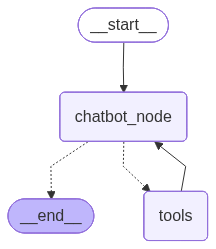

In [29]:
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges(
    "chatbot_node",
    tools_condition
)
builder.add_edge("tools", "chatbot_node")
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
# Test 1: Simple query to verify tool calling works
print("=== Test 1: Simple stock price query ===")
state = {"messages": [{"role": "user", "content": "What is the stock price of MSFT?"}]}
state = graph.invoke(state)
print(state["messages"][-1].content)
print("\n")

=== Test 1: Simple stock price query ===


ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 8.562794299s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '8s'}]}}

In [ ]:
# Test 2: With system message to help LLM understand it should use tools
print("=== Test 2: Calculate cost with system message ===")
state = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant with access to stock price tools. Use the available tools to fetch stock prices when needed to answer questions. You can perform calculations based on the stock prices you fetch."},
        {"role": "user", "content": "If I want to buy 20 stocks of MSFT using the current price, how much will it cost?"}
    ]
}
state = graph.invoke(state)
print(state["messages"][-1].content)
print("\n")

In [ ]:
# Test 3: Rephrase to avoid "buy" trigger
print("=== Test 3: Calculate without 'buy' word ===")
state = {"messages": [{"role": "user", "content": "Calculate the total cost of 20 MSFT shares at the current price."}]}
state = graph.invoke(state)
print(state["messages"][-1].content)